In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import ast
import shutil
import random 

In [3]:
train_images = "../input/table-tennis-ball-position-detection-dataset/openttgames/openttgames/images/train/"
test_images = "../input/table-tennis-ball-position-detection-dataset/openttgames/openttgames/images/test/"
train_labels = "../input/table-tennis-ball-position-detection-dataset/openttgames/openttgames/labels/train/"
test_labels = "../input/table-tennis-ball-position-detection-dataset/openttgames/openttgames/labels/test/"

image_name = "100.png"
image = cv2.imread(train_images + image_name, cv2.IMREAD_COLOR)

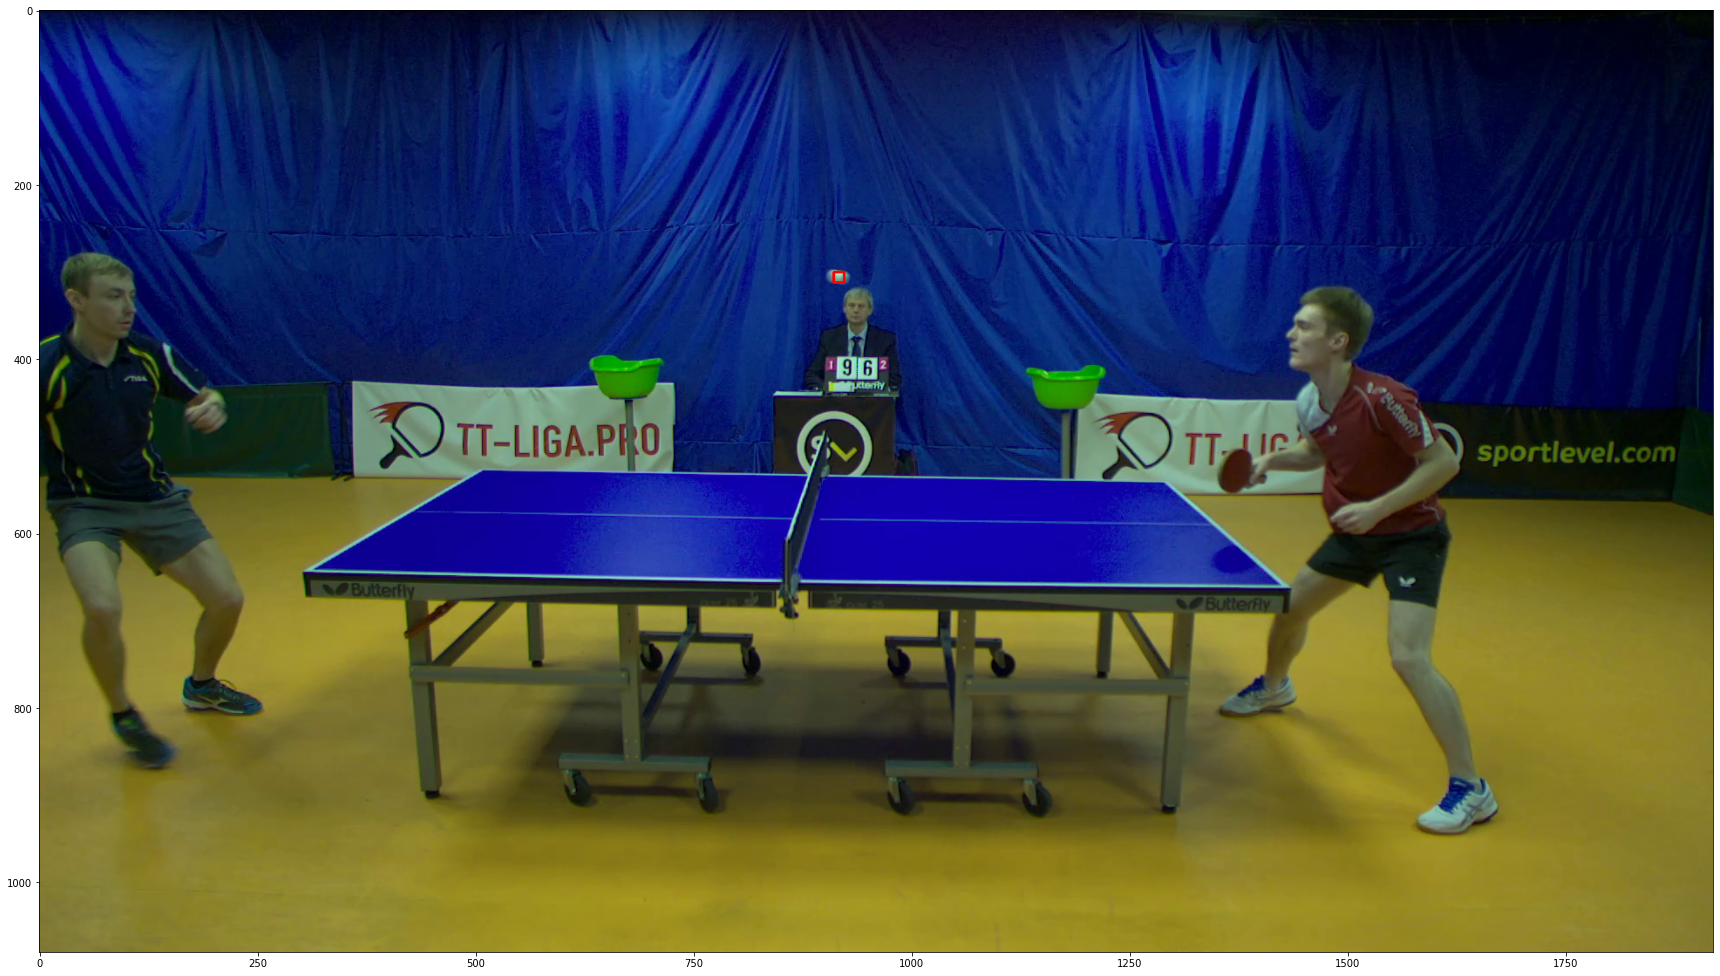

In [4]:
# YOLO format <object-class> <x> <y> <width> <height>
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

width = image_rgb.shape[1]
height = image_rgb.shape[0]

with open(train_labels + image_name[:-4] + ".txt") as label:
    data = map(float, label.readline().split())
    list_of_yolo_data = list(data)

if list_of_yolo_data:
    # For rectangle
    x1 = int(width * list_of_yolo_data[1] - width * list_of_yolo_data[3] / 2)
    y1 = int(height * list_of_yolo_data[2] - height * list_of_yolo_data[4] / 2)
    x2 = int(width * list_of_yolo_data[1] + width * list_of_yolo_data[3] / 2)
    y2 = int(height * list_of_yolo_data[2] + height * list_of_yolo_data[4] / 2)
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
   

fig, ax = plt.subplots(figsize=(30,30))
ax.imshow(image_rgb)

# **YOLO v5 installation and preparing**
**Import of important libraries and methods**

In [5]:
import torch
from IPython.display import Image, clear_output

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")


Setup complete. Using torch 1.11.0+cpu (CPU)


In [6]:
# clone repo
!git clone https://github.com/ultralytics/yolov5.git  

# change the working directory to yolov5
%cd yolov5
os.chdir('/kaggle/working/yolov5')


# install dependencies
%pip install -qr requirements.txt 

# Change the working directory back to /kaggle/working/
os.chdir('/kaggle/working/')

!pwd

Cloning into 'yolov5'...
remote: Enumerating objects: 12012, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 12012 (delta 8), reused 10 (delta 4), pack-reused 11984
Receiving objects: 100% (12012/12012), 12.55 MiB | 18.92 MiB/s, done.
Resolving deltas: 100% (8247/8247), done.
/kaggle/working/yolov5
Note: you may need to restart the kernel to use updated packages.
/kaggle/working


In [7]:
os.chdir('/kaggle/working/yolov5')

!pwd

/kaggle/working/yolov5


In [8]:
# Create a new directory (this is happening inside the yolov5 directory)

base_dir = 'base_dir'
os.mkdir(base_dir)

In [9]:
# images
images = os.path.join(base_dir, 'images')
os.mkdir(images)

# labels
labels = os.path.join(base_dir, 'labels')
os.mkdir(labels)

# Inside each folder we create seperate folders for each class

# create new folders inside images
train = os.path.join(images, 'train')
os.mkdir(train)
test = os.path.join(images, 'test')
os.mkdir(test)


# create new folders inside labels
train = os.path.join(labels, 'train')
os.mkdir(train)
test = os.path.join(labels, 'test')
os.mkdir(test)

In [10]:
# Display the folder structure

!tree base_dir

base_dir
├── images
│   ├── test
│   └── train
└── labels
    ├── test
    └── train

6 directories, 0 files


In [11]:
yaml_dict = {'train': 'base_dir/images/train',   # path to the train folder
             'val': 'base_dir/images/test',      # path to the test folder
             'nc': 1,                            # number of classes
             'names': ['ball']}                  # list of label names

In [12]:
import yaml

with open(r'openttgames.yaml', 'w') as file:
    documents = yaml.dump(yaml_dict, file)

In [13]:
! cat 'openttgames.yaml'

names:
- ball
nc: 1
train: base_dir/images/train
val: base_dir/images/test


In [14]:
os.chdir('/kaggle/working/')

!pwd

/kaggle/working


In [15]:
train_image_files = os.listdir(train_images)
test_image_files = os.listdir(test_images)

train_label_files = os.listdir(train_labels)
test_label_files = os.listdir(test_labels)

In [17]:
images_without_labels = []

for image_file in train_image_files:
    label_file = image_file[:-4] + ".txt"
    if label_file not in train_label_files:
        images_without_labels.append(image_file)
        train_image_files.remove(image_file)
print("Train images without labels: ", len(images_without_labels))


for image_file in test_image_files:
    label_file = image_file[:-4] + ".txt"
    if label_file not in test_label_files:
        images_without_labels.append(image_file)
        test_image_files.remove(image_file)
print("Test images without labels: ", len(images_without_labels))

Train images without labels:  5
Test images without labels:  5


In [18]:

v1_train_images, v1_train_labels, v1_test_images, v1_test_labels = [], [], [], []
v2_train_images, v2_train_labels, v2_test_images, v2_test_labels = [], [], [], []
v3_train_images, v3_train_labels, v3_test_images, v3_test_labels = [], [], [], []

#game_file_counter = 0

for file in train_image_files:
    if "_2.png" in file:
        v2_train_images.append(file)
    elif "_3.png" in file:
        v3_train_images.append(file)    
    else:
        v1_train_images.append(file)
        
for file in test_image_files:
    if "_2.png" in file:
        v2_test_images.append(file)
    elif "_3.png" in file:
        v3_test_images.append(file)    
    else:
        v1_test_images.append(file)

In [19]:
mixed_train_images = []
mixed_train_images.extend(random.choices(v1_train_images, k=2000))
mixed_train_images.extend(random.choices(v2_train_images, k=2000))
mixed_train_images.extend(random.choices(v3_train_images, k=2000))

mixed_test_images = []
mixed_test_images.extend(random.choices(v1_test_images, k=200))
mixed_test_images.extend(random.choices(v2_test_images, k=200))
mixed_test_images.extend(random.choices(v3_test_images, k=200))

mixed_train_labels = []
mixed_test_labels = []
        
for image_file in mixed_train_images:
    mixed_train_labels.append(image_file[:-4] + ".txt")

for image_file in mixed_test_images:
    mixed_test_labels.append(image_file[:-4] + ".txt")   
        
print(len(mixed_train_images))
print(len(mixed_test_images))
print(len(mixed_train_labels))
print(len(mixed_test_labels))

6000
600
6000
600


In [22]:
for i in range(6000):
    shutil.copyfile(train_images + mixed_train_images[i], "/kaggle/working/yolov5/base_dir/images/train/" + mixed_train_images[i])
    shutil.copyfile(train_labels + mixed_train_labels[i], "/kaggle/working/yolov5/base_dir/labels/train/" + mixed_train_labels[i])
    
for i in range(600):
    shutil.copyfile(test_images + mixed_test_images[i], "/kaggle/working/yolov5/base_dir/images/test/" + mixed_test_images[i])
    shutil.copyfile(test_labels + mixed_test_labels[i], "/kaggle/working/yolov5/base_dir/labels/test/" + mixed_test_labels[i])

In [23]:
# os.listdir("/kaggle/working/yolov5/base_dir/images/train/")

In [24]:
# Install W&B 
!pip install -q --upgrade wandb

# Login 
import wandb
wandb.login()

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.
allennlp 2.10.0 requires wandb<0.13.0,>=0.10.0, but you have wandb 0.13.2 which is incompatible.


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [19]:
os.chdir('/kaggle/working/yolov5/')

!python train.py --batch 50 \
                 --epochs 10 \
                 --freeze 10 \
                 --data /kaggle/working/yolov5/openttgames.yaml \
                 --name yolov5_training \
                 --project table-tennis-yolov5_mixed_videos

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=/kaggle/working/yolov5/openttgames.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=1, batch_size=30, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=table-tennis-yolov5, name=yolov5_train, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-53-gf0e5a60 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparamet

In [ ]:
# Save files
import shutil
shutil.make_archive("weights", 'zip', "table-tennis-yolov5_mixed_videos/yolov5_training/weights" )

In [ ]:
!python detect.py --conf 0.25 \
                  --source /kaggle/working/yolov5/base_dir/images/test \
                  --save-txt True \
                  --max_det=1 \
                  --save-conf \
                  --exist-ok \
                  --project --project table-tennis-yolov5_mixed_videos